In [8]:
import torch
import torch.nn as nn

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=200, device='cpu'):
        super(PositionalEncoding, self).__init__()
        self.pos_table = self._get_sinusoid_encoding_table(max_len, d_model, device)

    def _get_sinusoid_encoding_table(self, max_seq_len, d_hid, device):
        position = torch.arange(0, max_seq_len, device=device).float().unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_hid, 2, device=device).float() * -(torch.log(torch.tensor(10000.0)) / d_hid))
        
        sinusoid_table = torch.zeros(max_seq_len, d_hid, device=device)
        sinusoid_table[:, 0::2] = torch.sin(position * div_term)
        sinusoid_table[:, 1::2] = torch.cos(position * div_term)

        return sinusoid_table.unsqueeze(0)

    def forward(self, x):
        return x + self.pos_table[:, :x.size(1)].clone().detach()

# Initialize Positional Encoding
d_model = 8
max_len = 10
pos_enc = PositionalEncoding(d_model, max_len)

# Generate example data
batch_size = 1
seq_len = 5
x = torch.rand(batch_size, seq_len, d_model)

print("Original Input:\n", x)
print("input shape:", x.shape)

# Apply Positional Encoding
x_encoded = pos_enc(x)

print("\nPositional Encoded Input:\n", x_encoded)
print("output shape", x_encoded.shape)

Original Input:
 tensor([[[0.3850, 0.5385, 0.9373, 0.9378, 0.4698, 0.5875, 0.2967, 0.9103],
         [0.2427, 0.0146, 0.1008, 0.7644, 0.5750, 0.4641, 0.2080, 0.3063],
         [0.5608, 0.6441, 0.6097, 0.7116, 0.2767, 0.1115, 0.8490, 0.5207],
         [0.0299, 0.7309, 0.8054, 0.1917, 0.0828, 0.1358, 0.8224, 0.0253],
         [0.8246, 0.2751, 0.3948, 0.2837, 0.4042, 0.0490, 0.5056, 0.6815]]])
input shape: torch.Size([1, 5, 8])

Positional Encoded Input:
 tensor([[[ 0.3850,  1.5385,  0.9373,  1.9378,  0.4698,  1.5875,  0.2967,
           1.9103],
         [ 1.0842,  0.5549,  0.2006,  1.7595,  0.5850,  1.4640,  0.2090,
           1.3063],
         [ 1.4701,  0.2279,  0.8084,  1.6916,  0.2967,  1.1113,  0.8510,
           1.5207],
         [ 0.1710, -0.2591,  1.1009,  1.1470,  0.1128,  1.1353,  0.8254,
           1.0253],
         [ 0.0678, -0.3786,  0.7842,  1.2048,  0.4441,  1.0482,  0.5096,
           1.6815]]])
output shape torch.Size([1, 5, 8])


In [29]:
import json
import numpy as np
import matplotlib.pyplot as plt 
loc_data_path = "/home/lixiang/e2eloc_data/data.json"

pre_errors_xy = []
pre_errors_yaw = []

errors_yaw = []

xy_gt = []
xy_pre = []
yaw_gt = []
yaw_pre = []

assert(loc_data_path is not None)

with open(loc_data_path, "r") as f:
    data = [json.loads(line) for line in f]
    xy_gt = data[0]["xy_gt"]
    xy_pre = data[0]["xy_pre"]
    yaw_gt = data[0]["yaw_gt"]
    yaw_pre = data[0]["yaw_pre"]
    assert len(xy_gt) == len(xy_pre)
    assert len(yaw_gt) == len(yaw_pre)
    for gt, pre in zip(xy_gt, xy_pre):
        error = np.linalg.norm(np.array(gt) - np.array(pre))
        pre_errors_xy.append(error)
    formatted_xy_pre = [[f"{x:.1f}", f"{y:.1f}"] for x, y in xy_pre[:20]]
    formatted_yaw_pre = [f"{yaw:.1f}" for yaw in yaw_pre[:20]]
    print("First 10 xy_pre:", formatted_xy_pre)
    print("First 10 yaw_pre:", formatted_yaw_pre)
    

First 10 xy_pre: [['149.8', '152.5'], ['149.6', '152.0'], ['143.7', '152.1'], ['140.4', '152.1'], ['139.2', '152.1'], ['140.8', '152.0'], ['138.4', '151.8'], ['127.2', '151.9'], ['123.9', '151.9'], ['132.9', '152.2'], ['122.8', '152.6'], ['117.5', '152.3'], ['117.0', '151.9'], ['101.4', '153.1'], ['117.7', '153.1'], ['100.5', '151.9'], ['97.4', '152.2'], ['94.8', '152.2'], ['91.3', '152.3'], ['93.1', '151.8']]
First 10 yaw_pre: ['86.3', '90.6', '90.3', '90.1', '90.5', '89.8', '89.7', '92.2', '90.3', '90.8', '90.3', '89.9', '90.8', '90.9', '89.5', '90.5', '90.4', '90.4', '90.2', '90.3']


In [174]:
def plot_error_xy_hist(errors, save_pic_path=None):
	plt.figure(figsize=(8, 6))
	plt.hist(errors, bins=100, color="blue", alpha=0.3)
	plt.xlabel("Error")
	plt.ylabel("Frequency")
	plt.title("Error Distribution")
	if save_pic_path:
		plt.savefig("./" + save_pic_path + ".png")
		print(f"图像已保存为 {save_pic_path}")
	else:
		plt.show()

In [163]:
class KalmanFilter:
    def __init__(self, process_noise=1.0, measurement_noise=1.0, estimation_error=1.0, initial_state=None):
        # 状态向量包括 [x, y, theta, v_x, v_y, v_theta]
        self.A = np.eye(6)
        self.H = np.eye(3, 6)  # 观测矩阵
        self.Q = np.eye(6) * process_noise
        self.R = np.eye(3) * measurement_noise
        self.P = np.eye(6) * estimation_error
        
        if initial_state is not None:
            self.x = np.hstack((initial_state, np.zeros(3))) 
        else:
            self.x = np.zeros(6)

    def predict(self, delta_time=0.0):
        self.A[0, 3] = delta_time
        self.A[1, 4] = delta_time
        self.A[2, 5] = delta_time
        
        self.x = np.dot(self.A, self.x)
        self.P = np.dot(self.A, np.dot(self.P, self.A.T)) + self.Q

    def update(self, z):
        y = z - np.dot(self.H, self.x)
        S = np.dot(self.H, np.dot(self.P, self.H.T)) + self.R
        K = np.dot(self.P, np.dot(self.H.T, np.linalg.inv(S)))

        self.x = self.x + np.dot(K, y)
        self.P = self.P - np.dot(K, np.dot(self.H, self.P))

    def get_state(self):
        return self.x

    def set_velocity(self, velocity):
        self.x[3:] = velocity  # 更新速度部分

In [176]:
class PoseOptimizer:
    def __init__(self, window_size=20, threshold_factor=1, distance_thr=10, inital_state=None):
        self.window_size = window_size
        self.history = []
        self.timestamps = []
        self.threshold_factor = threshold_factor
        self.distance_thr = distance_thr
        self.cnt = 0
        self.kalman = KalmanFilter(initial_state=inital_state)

    # 添加历史位姿
    def add_pose(self, pose, timestamp=None):
        self.history.append(pose)
        if timestamp is not None:
            self.timestamps.append(timestamp)
        
        if len(self.history) > self.window_size:
            self.history.pop(0)
            if timestamp is not None:
                self.timestamps.pop(0)

    # def calculate_statistics(self):
    #     deltas = np.diff(np.array(self.history), axis=0)
    #     # print("deltas",deltas)
    #     delta_positions = deltas[:, :2]
    #     delta_yaws = deltas[:, 2]

    #     mean_delta_position = np.mean(delta_positions, axis=0)
    #     std_delta_position = np.std(delta_positions, axis=0)

    #     mean_delta_yaw = np.mean(delta_yaws)
    #     std_delta_yaw = np.std(delta_yaws)

    #     return mean_delta_position, std_delta_position, mean_delta_yaw, std_delta_yaw
    
    def calculate_velocity(self):
        if len(self.timestamps) < 2:
            return np.zeros(3)
        
        velocities = []
        for i in range(1, len(self.timestamps)):
            delta_time = self.timestamps[i] - self.timestamps[i - 1]
            if delta_time > 0:
                delta_position = np.array(self.history[i][:]) - np.array(self.history[i - 1][:])
                velocity = delta_position / delta_time
                velocities.append(velocity)

        mean_velocity = np.mean(velocities, axis=0)
        return mean_velocity
     

    def optimize_pose(self, current_pose, odometry_pose, current_timestamp=None):
        if len(self.history) < 2:
            return current_pose
        # mean_delta_position, std_delta_position, mean_delta_yaw, std_delta_yaw = self.calculate_statistics()
        mean_velocity = self.calculate_velocity()
        self.kalman.set_velocity(mean_velocity)  # 更新速度
        
        last_pose = np.array(self.history[-1])

        # delta_position = current_delta[:2]
        # delta_yaw = current_delta[2]
        
        # cur_dis = np.linalg.norm(delta_position)

        # 检查变化量是否在标准差阈值内
        # position_within_threshold = np.all(np.abs(delta_position - mean_delta_position) <= self.threshold_factor * std_delta_position)
        # yaw_within_threshold = np.abs(delta_yaw - mean_delta_yaw) <= self.threshold_factor * std_delta_yaw

        # if position_within_threshold or yaw_within_threshold or cur_dis < self.distance_thr:
        #     return current_pose
        
        delta_time = 1.0
        if current_timestamp is not None and self.timestamps:
            delta_time = current_timestamp - self.timestamps[-1] # 时间更新
        
        self.kalman.predict(delta_time=delta_time)
        self.kalman.update(np.array(odometry_pose))
        optimized_state = self.kalman.get_state()
        
        optimized_pose = [optimized_state[0], optimized_state[1], optimized_state[2]]
        current_delta = np.array(optimized_pose) - last_pose
        cur_dis = np.linalg.norm(current_delta)
        
        if (cur_dis > 10):
            print("distance over 10meters", cur_dis)
            return current_pose
        # delta_position = current_delta[:2]
        # cur_dis = np.linalg.norm(delta_position)
        return optimized_pose
        
        # if current_timestamp is not None and self.timestamps:
        #     delta_time = current_timestamp - self.timestamps[-1]
        #     if delta_time > 0:
        #         estimated_position = last_pose[:2] + mean_velocity * delta_time
        #         estimated_pose = np.array([estimated_position[0], estimated_position[1], current_pose[2]])
        #         self.kalman.update(estimated_pose)
            
		# self.kalman.update(np.array(current_pose))


        # print("当前标准差", std_delta_position)
        
        # optimized_position = np.array(last_pose[:2]) * 0.2 + np.array(current_pose[:2]) * 0.8
        # optimized_yaw = last_pose[2] * 0.2 + current_pose[2] * 0.8

        # return current_pose[0], current_pose[1], current_pose[2]



In [177]:
# 示例使用
optimizer = PoseOptimizer(threshold_factor=3)
initial_poses = [xy_gt[i] + [yaw_gt[i]] for i in range(5)]
# initial_poses
for i in range(5):
    pose = xy_gt[i] + [yaw_gt[i]]
    timestamp = i  # 示例时间戳
    optimizer.add_pose(pose, timestamp)

In [178]:
smoothed_poses = [pose for pose in initial_poses]
for i in range(5, len(xy_gt)):
    odometry_noise = np.random.normal(0.01, 0.1, size=2)  # 添加噪声
    odometry_pose = [xy_gt[i][0] + odometry_noise[0], xy_gt[i][1] + odometry_noise[1], yaw_gt[i]]
    current_pose = xy_pre[i] + [yaw_pre[i]]
    current_timestamp = i  # 示例时间戳
    optimized_pose = optimizer.optimize_pose(current_pose, odometry_pose, current_timestamp)
    smoothed_poses.append(optimized_pose)
    optimizer.add_pose(optimized_pose, current_timestamp)

distance over 10meters 57.88575481352798
distance over 10meters 14.456517951776222
distance over 10meters 12.822701413885445
distance over 10meters 27.29474816280218
distance over 10meters 14.378352746347936
distance over 10meters 14.781533381671952
distance over 10meters 292.4775952321824
distance over 10meters 15.578057008689106
distance over 10meters 13.24992516666009
distance over 10meters 12.79841200713029
distance over 10meters 10.89627513804644
distance over 10meters 11.092686155485563
distance over 10meters 13.679246896595423
distance over 10meters 11.438404530514399
distance over 10meters 14.57245859029509
distance over 10meters 10.477883283858455
distance over 10meters 15.491477520706644
distance over 10meters 13.91492226287726
distance over 10meters 12.398208080854094
distance over 10meters 12.427597765342755
distance over 10meters 23.456360569422866
distance over 10meters 16.308968765552756
distance over 10meters 39.54854750266934
distance over 10meters 12.918965306378244
d

In [179]:
print("Smoothed Poses:" , len(smoothed_poses))
# for pose in smoothed_poses:
#     print(f"x: {pose[0]:.1f}, y: {pose[1]:.1f}, yaw: {pose[2]:.1f}")
    
len(xy_pre) == len(smoothed_poses)

Smoothed Poses: 240


True

In [180]:
smoothed_xy = [[pose[0], pose[1]] for pose in smoothed_poses]
errors_xy = []
for gt, pre_smoothed in zip(xy_gt, smoothed_xy):
	error = np.linalg.norm(np.array(gt) - np.array(pre_smoothed))
	errors_xy.append(error)


图像已保存为 error_distribution_filted


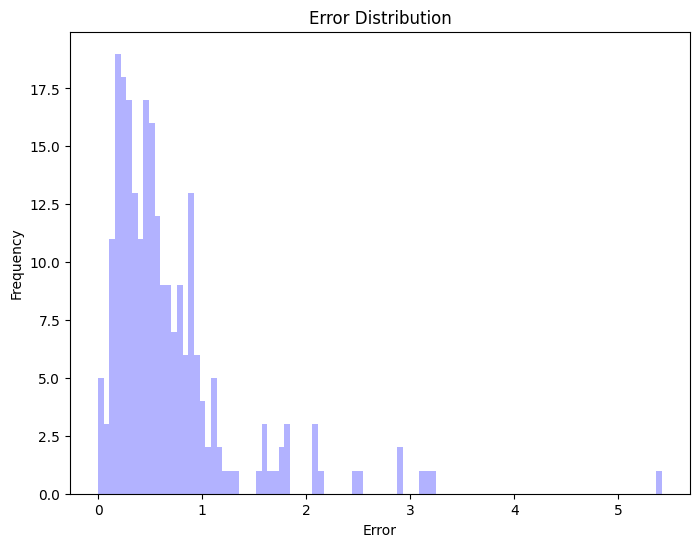

In [181]:
plot_error_xy_hist(errors_xy, "error_distribution_filted")

图像已保存为 error_distribution_original


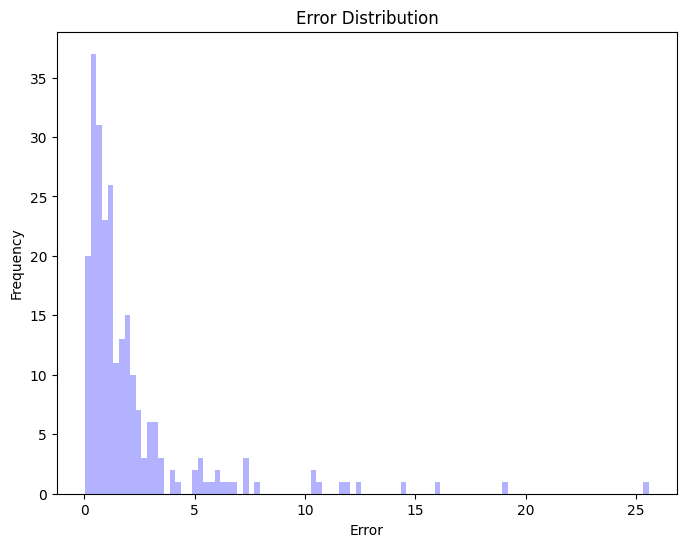

In [183]:
plot_error_xy_hist(pre_errors_xy, "error_distribution_original")